# RGU-IIT CBR Test Dataset Retrieval Analysis

## Imports

In [64]:
!pip install datasets

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from google.colab import files
from io import BytesIO
from heapq import nlargest
from tqdm import tqdm
from datasets import load_dataset, Dataset, DatasetDict

## Mathematical functions

In [65]:
def calculate_recall(actual_items, predicted_items):
    intersection = len(set(actual_items) & set(predicted_items))
    if len(actual_items) == 0:
        return 0
    else:
        return intersection / len(actual_items)

def calculate_precision(actual_items, predicted_items):
    intersection = len(set(actual_items) & set(predicted_items))
    if len(predicted_items) == 0:
        return 0
    else:
        return intersection / len(predicted_items)

def calculate_f_score(actual_items, predicted_items, beta=1):
    intersection = len(set(actual_items) & set(predicted_items))
    precision = calculate_precision(actual_items, predicted_items)
    recall = calculate_recall(actual_items, predicted_items)
    if precision == 0 and recall == 0:
        return 0
    f_score = (1 + beta**2) * ((precision * recall) / ((beta**2 * precision) + recall))
    return f_score

Dataset loading and row selection

In [66]:
df_results = pd.DataFrame('resources/k_test_retrieval_results.csv')
df_original_data = pd.DataFrame(dataset_original_data['resources/test_dataset.csv'])

In [67]:
selected_columns = [
                    'normal_bert_pipeline_2_case_indexes',
                    'normal_bert_pipeline_4_case_indexes',
                    'normal_bert_pipeline_6_case_indexes',
                    'normal_bert_pipeline_8_case_indexes',
                    'normal_bert_pipeline_10_case_indexes',
                    'normal_bert_pipeline_12_case_indexes',
                    'legal_bert_pipeline_2_case_indexes',
                    'legal_bert_pipeline_4_case_indexes',
                    'legal_bert_pipeline_6_case_indexes',
                    'legal_bert_pipeline_8_case_indexes',
                    'legal_bert_pipeline_10_case_indexes',
                    'legal_bert_pipeline_12_case_indexes',
                    'angle_bert_pipeline_2_case_indexes',
                    'angle_bert_pipeline_4_case_indexes',
                    'angle_bert_pipeline_6_case_indexes',
                    'angle_bert_pipeline_8_case_indexes',
                    'angle_bert_pipeline_10_case_indexes',
                    'angle_bert_pipeline_12_case_indexes'
                    ]
df_selected_results = df_results.loc[:, selected_columns]
merged_df = pd.merge(df_selected_results, df_original_data, left_index=True, right_index=True)
merged_df.drop(index=[3, 33, 26], inplace=True)
merged_df.reset_index(drop=True, inplace=True)
print(len(merged_df))

32


## Index based statistics

In [68]:
def get_indexes(item1, item2, lst):
    indexes = []
    for i in range(len(lst)):
        if lst[i] == item1 or lst[i] == item2:
            indexes.append(i)

    if (len(indexes) == 1):
        return indexes[0], indexes[0]
    if indexes[0] > indexes[1]:
        return indexes[1], indexes[0]
    return indexes[0], indexes[1]

min_values = {}
max_values = {}
for index, row in merged_df.iterrows():
    for column in merged_df.columns:
        if column.endswith('_case_indexes'):
            min_val, max_val = get_indexes(row['original_texts'][0], row['original_texts'][1], row[column])

            if column in min_values:
                min_values[column].append(min_val)
            else:
                min_values[column] = [min_val]

            if column in max_values:
                max_values[column].append(max_val)
            else:
                max_values[column] = [max_val]

avg_min_values = {}
for column in min_values:
    avg_min_values[column] = sum(min_values[column]) / len(min_values[column])

avg_max_values = {}
for column in max_values:
    avg_max_values[column] = sum(max_values[column]) / len(max_values[column])

for column in avg_min_values:
    print(f"Column: {column} - Average min value: {avg_min_values[column]}")
    print(f"Column: {column} - Average max value: {avg_max_values[column]}")
    print(f"Column: {column} - Average value: {(avg_min_values[column] + avg_max_values[column]) / 2}")
    print("-------------------------")

Column: normal_bert_pipeline_2_case_indexes - Average min value: 86.5625
Column: normal_bert_pipeline_2_case_indexes - Average max value: 357.78125
Column: normal_bert_pipeline_2_case_indexes - Average value: 222.171875
-------------------------
Column: normal_bert_pipeline_4_case_indexes - Average min value: 139.34375
Column: normal_bert_pipeline_4_case_indexes - Average max value: 330.875
Column: normal_bert_pipeline_4_case_indexes - Average value: 235.109375
-------------------------
Column: normal_bert_pipeline_6_case_indexes - Average min value: 103.96875
Column: normal_bert_pipeline_6_case_indexes - Average max value: 319.78125
Column: normal_bert_pipeline_6_case_indexes - Average value: 211.875
-------------------------
Column: normal_bert_pipeline_8_case_indexes - Average min value: 63.90625
Column: normal_bert_pipeline_8_case_indexes - Average max value: 201.0625
Column: normal_bert_pipeline_8_case_indexes - Average value: 132.484375
-------------------------
Column: normal_be

Define k ranges

In [69]:
k_values = [1, 3, 5, 7, 9, 13, 19, 23, 37]

## Calculate avrage f-scores

In [70]:
f_score_data = {}
precision_data = {}

for k in k_values:
    f_score_values = {}
    for index, row in merged_df.iterrows():
        for column in merged_df.columns:
            if column.endswith('_case_indexes'):
                f_score = calculate_f_score(row['original_texts'], row[column][:k])

                if column in f_score_values:
                    f_score_values[column].append(f_score)
                else:
                    f_score_values[column] = [f_score]

    f_score_df = pd.DataFrame(f_score_values)
    f_score_data[k] = f_score_df

# Calculate average F-score per k per column
average_f_score_data = {}
for k, f_score_df in f_score_data.items():
    average_f_score_data[k] = f_score_df.mean()

average_f_score_df = pd.DataFrame(average_f_score_data)

Rename columns

In [71]:
rename_dict = {
    'normal_bert_pipeline_2_case_indexes': 'BERT [1,0,0]',
    'normal_bert_pipeline_4_case_indexes': 'BERT [0,1,0]',
    'normal_bert_pipeline_6_case_indexes': 'BERT [0,0,1]',
    'normal_bert_pipeline_8_case_indexes': 'BERT [0.20,0.40,0.40]',
    'normal_bert_pipeline_10_case_indexes': 'BERT [0.30,0.40,0.30]',
    'normal_bert_pipeline_12_case_indexes': 'BERT [0.25,0.40,0.35]',
    'legal_bert_pipeline_2_case_indexes': 'LegalBERT [1,0,0]',
    'legal_bert_pipeline_4_case_indexes': 'LegalBERT [0,1,0]',
    'legal_bert_pipeline_6_case_indexes': 'LegalBERT [0,0,1]',
    'legal_bert_pipeline_8_case_indexes': 'LegalBERT [0.20,0.40,0.40]',
    'legal_bert_pipeline_10_case_indexes': 'LegalBERT [0.30,0.40,0.30]',
    'legal_bert_pipeline_12_case_indexes': 'LegalBERT [0.25,0.40,0.35]',
    'angle_bert_pipeline_2_case_indexes': 'AnglEBERT [1,0,0]',
    'angle_bert_pipeline_4_case_indexes': 'AnglEBERT [0,1,0]',
    'angle_bert_pipeline_6_case_indexes': 'AnglEBERT [0,0,1]',
    'angle_bert_pipeline_8_case_indexes': 'AnglEBERT [0.20,0.40,0.40]',
    'angle_bert_pipeline_10_case_indexes': 'AnglEBERT [0.30,0.40,0.30]',
    'angle_bert_pipeline_12_case_indexes': 'AnglEBERT [0.25,0.40,0.35]'
}

average_f_score_df.index = average_f_score_df.index.map(rename_dict.get)

## Show heatmap

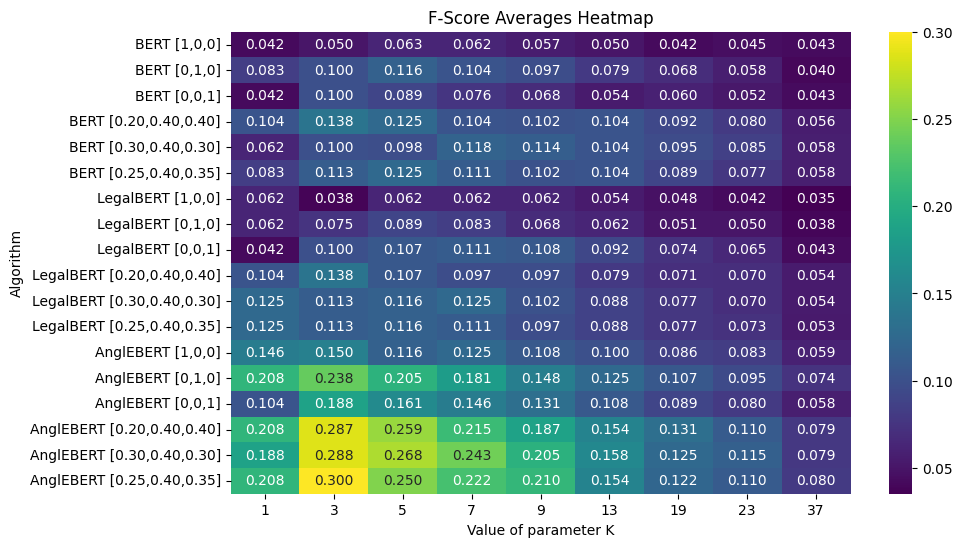

In [72]:
plt.figure(figsize=(10, 6))
sns.heatmap(average_f_score_df, cmap='viridis', annot=True, fmt=".3f")
plt.title('F-Score Averages Heatmap')
plt.xlabel('Value of parameter K')
plt.ylabel('Algorithm')
plt.show()